# 9. Diagnostics 诊断
Prophet包含时间序列交叉验证功能，以测量使用历史数据的预测误差。这是通过在历史记录中选择截止点来完成的，对于每一个都只使用该截止点之前的数据来拟合模型。然后，我们可以将预测值与实际值进行比较。这张图展示了对Peyton Manning数据集的模拟历史预测，该模型适用于5年的初始历史，并在1年的时间范围内进行了预测。
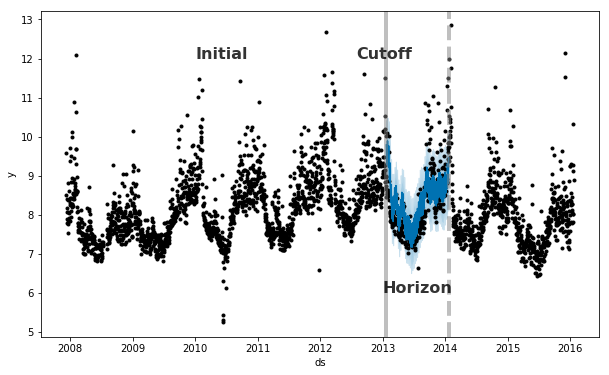
[源论文](https://peerj.com/preprints/3190.pdf)中进一步描述了模拟的历史预测。

这个交叉验证过程可以使用**cross_validation**函数自动完成一系列历史截断。我们指定预测水平(**horizon**)，然后选择初始训练期(**initial**)的大小和截断之间的间隔(**period**)。默认情况下，初始训练期设置为**horizon**的三倍，每半个**horizon**就有一个截断。

**注：这里需要解释下horizon，initial和period的意义：initial代表了一开始的时间是多少，period代表每隔多长时间设置一个cutoff，horizon代表每次从cutoff往后预测多少天。**

cross_validation的输出是一个dataframe，在每个模拟预测日期和每个截断日期都有真实值**y**和样本预测值**yhat**。特别地，对在**cutoff** 和**cutoff + horizon**之间的每一个观测点都进行了预测。然后，这个dataframe可以用来度量**yhat**和**y**的错误。

在这里，我们做交叉验证来评估预测**horizon**在365天的性能，从第一次截止时730天的训练数据开始，然后每180天进行一次预测。在这个8年的时间序列中，这相当于11个总预测。

注：Peyton Manning数据一共大约8年多（**2007/12/10 - 2016/01/20**）的数据。

根据上面对**horizon，initial和period**的解释：容易得到为什么是11个总预测。因为最后一个也要预测365天，所有最后一个cutoff在2015-01-20，从2007-12-19数730天是2010-02-15，则在2010-02-15到2015-01-20共有1800天，对应着10个cutoff，最后1个cutoff在2015-01-20，因此共11个cutoff。

In [2]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

df = pd.read_csv('examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\PC-00001\Miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.955671,8.513038,9.456789,8.242493,2010-02-15
1,2010-02-17,8.722033,8.214253,9.233864,8.008033,2010-02-15
2,2010-02-18,8.605714,8.111359,9.129989,8.045268,2010-02-15
3,2010-02-19,8.527519,8.051418,9.003267,7.928766,2010-02-15
4,2010-02-20,8.269416,7.759844,8.788222,7.745003,2010-02-15


**performance_metrics**作为离截止点(预测的未来距离)的函数，可用于计算关于预测性能的一些有用统计数据(**如与y相比时yhat、yhat_lower和yhat_upper**)。计算得到的统计信息包括均方误差(mean squared error, MSE)、均方根误差(root mean squared error, RMSE)、平均绝对误差(mean absolute error, MAE)、平均绝对误差(mean absolute percent error, MAPE)以及yhat_lower和yhat_upper估计的覆盖率。这些都是在df_cv中通过**horizon** (ds - cutoff)排序后预测的滚动窗口中计算出来的。默认情况下，每个窗口都会包含10%的预测，但是可以通过**rolling_window**参数来更改。

In [3]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,0.496237,0.704441,0.506810,0.058729,0.676565
1,38 days,0.502152,0.708627,0.511809,0.059308,0.676565
2,39 days,0.524343,0.724115,0.517909,0.059907,0.675194
3,40 days,0.531495,0.729037,0.520775,0.060214,0.673824
4,41 days,0.538777,0.734014,0.521728,0.060288,0.681361


交叉验证性能指标可以用**plot_cross_validation_metric**可视化，这里显示的是MAPE。点表示df_cv中每个预测的绝对误差百分比。蓝线显示的是MAPE，均值被取到滚动窗口的圆点。我们可以看到，对于一个月后的预测，误差在5%左右，而对于一年之后的预测，误差会增加到11%左右。

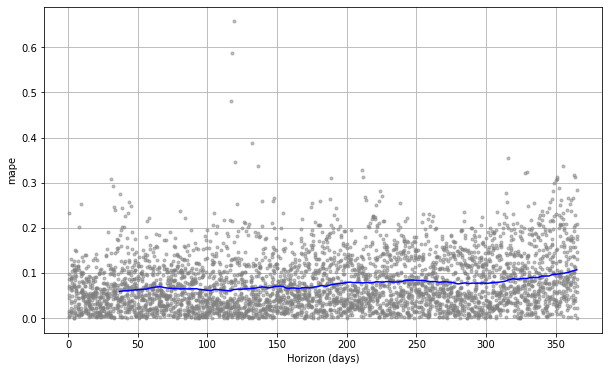

In [4]:
# Python
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

图中滚动窗口的大小可以通过可选参数**rolling_window**更改，该参数指定在每个滚动窗口中使用的预测比例。默认值为0.1，即每个窗口中包含的df_cv的10%行;增大值得话将导致图中平均曲线更平滑。

初始周期应该足够长，以捕获模型的所有特性，特别是季节性和额外的回归变量:对年的季节性至少保证一年，对周的季节性至少保证一周，等等。